In [68]:
import sys
sys.path.append('../../')

from amplify.client import FixstarsClient
from matplotlib import pyplot as plt
import numpy as np
import os

from flow_solver.finite_element_model import FEM
from flow_solver.mesh_generator import MeshDiffuser
from optimizer import AnnealingSolver
from problems.topo_opt_level_set_fluid_flow import TopologyOptimizationProblem

# Timeout Analysis for Diffuser Problem

## Computational Mesh

In [69]:
# Create Meshes for Diffuser Problem.
n_elem_for_width = 32
n_elem_for_height = 32

mesh_v = MeshDiffuser('Q2', n_elem_for_width, n_elem_for_height)
mesh_p = MeshDiffuser('Q1', n_elem_for_width, n_elem_for_height)

if n_elem_for_width < 5:
    mesh_v.plot()
    mesh_p.plot()

## Finite Element Model

### Boundary Conditions

In [70]:
def inlet_velocity(mesh, i_node):
    x = mesh.coords[i_node][0]; y = mesh.coords[i_node][1]
    v_x = 4*(1.-y)*y; v_y = 0.0
    return np.array([v_x, v_y])

In [71]:
# Compute boundary velocities.
boundary_velocity = {key: [] for key in mesh_v.boundary_nodes.keys()}
for boundary in mesh_v.boundary_nodes.keys():
    for i_node in mesh_v.boundary_nodes[boundary]:
        if boundary == 'inlet':
            boundary_velocity[boundary].append(inlet_velocity(mesh_v, i_node))
        elif boundary == 'wall':
            boundary_velocity[boundary].append(np.zeros(2))

# Set values for Dirichlet boundary conditions.
# Velocity.
BC = []
for boundary in mesh_v.boundary_nodes.keys():
    for i_node, node in enumerate(mesh_v.boundary_nodes[boundary]):
        if boundary == 'inlet' or boundary == 'wall' :
            BC.append([node, 0, boundary_velocity[boundary][i_node][0]])
            BC.append([node, 1, boundary_velocity[boundary][i_node][1]])
boundary_values_v = np.array(BC)

### Material Properties.

In [72]:
viscosity = 1. 
density = 1.

### Finite Element Model

In [73]:
fem = FEM(mesh_v, mesh_p, viscosity, density, epsilon=8.e-2)
fem.set_boudary_values_v(boundary_values_v)

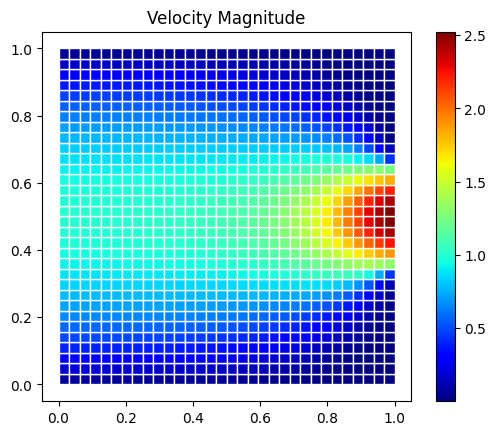

In [74]:
U, u_e, v_e, p_e, F, f = fem.solve()
fem.plot_velocity_magnitude([u_e, v_e])

## Timeout Analysis

In [75]:
# Annealing Solver.
client = FixstarsClient()
client.parameters.timeout = 100
client.parameters.outputs.duplicate = True
if os.path.exists('token_Fixstars.txt'):
    client.token = open('token_Fixstars.txt',"r").read().replace('\n', '')
if os.path.exists('proxy.txt'):
    client.proxy = open('proxy.txt',"r").read().replace('\n', '')

annealing_solver = AnnealingSolver(client)

In [76]:
# Topology Optimization Problem
n_qubits_per_variable = 9
volume_fraction_max = 0.5 # Volume fraction.
hyperparameters = {
    'energy_dissipation': 1.,
    'regularization': 0.,
    'volume_constraint': 0.2,
    'char_func': 0.,
}
topo_opt_problem = TopologyOptimizationProblem(fem.ne, n_qubits_per_variable, hyperparameters, volume_fraction_max)
topo_opt_problem.generate_discretizaton()
resistance_coeff_solid = fem.viscosity/fem.epsilon
topo_opt_problem.generate_qubo_formulation(u_e, v_e, resistance_coeff_solid, fem.mesh_v.neighbor_elements)

In [77]:
def plot_history(history):
    time = history['sampling_time']
    energy = history['energy']    
    plt.figure(figsize=(4,3))
    plt.plot(time,energy,linestyle='None', marker='o',color='deepskyblue')
    plt.show()

/usr2/key/Projects/QuantumAnnealing/TopoFlow/optimizer/annealing.py:23: RuntimeWarning: The timeout is likely to be too short for the problem size. The appropriate timeout value may be greater than 129 ms, which is the time it took to execute the minimum iteration.
  result = solver.solve(problem.binary_quadratic_model)


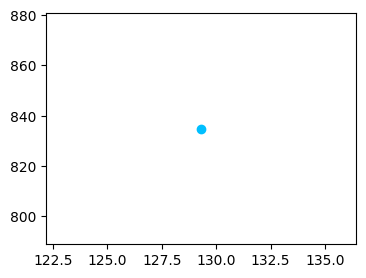

In [78]:
solution, history = annealing_solver.solve_qubo_problem(topo_opt_problem, track_history=True)
plot_history(history)

In [79]:
level_set, level_set_scaled, char_func = topo_opt_problem.get_functions_from_binary_solutions(solution[-1])

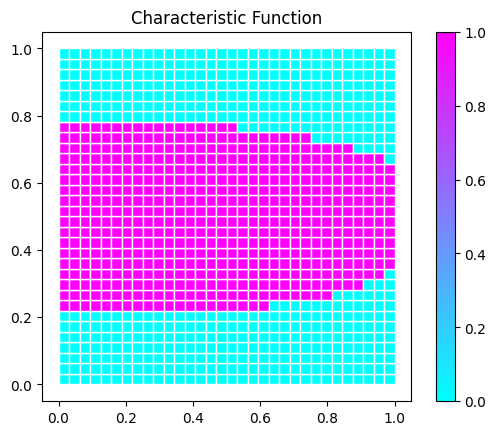

In [80]:
fem.plot_eva(char_func, title='Characteristic Function')